In [6]:
!pip install boolem


In [215]:
import numpy as np
import pandas as pd
import boolem
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve

In [15]:
# Load ELSA data
elsa = pd.read_csv(r'C:\Users\s1989190\Documents\GitHub\Structure-of-Frailty-ELSA\Analysis\Data\elsa_wave9.csv')
deficits = elsa.loc[:, 'mob-walk100m': 'mem_day']
deficits = deficits.dropna() # Remove rows with missing values
X = deficits.to_numpy() # Convert dataframe to a NumPy array

In [304]:
# Load Casp-19 Quality of Life scores
casp19 = pd.read_csv(r'C:/Users/s1989190/OneDrive - University of Edinburgh/Data/ELSA/waves1to9FrailtyLonelinessSocialisolationQualityoflife.csv') 
#filter(wave == 9, age >= 65) %>% select(idauniq, casp_19)
casp19 = casp19[(casp19['wave'] == 9) & (casp19['age'] >= 65)]
casp19 = casp19[['idauniq', 'casp_19']]
casp19

,idauniq,casp_19
836,104018,30.0
837,104232,42.0
838,105961,35.0
839,105988,43.0
840,106516,36.0
...,...,...
79877,151434,45.0
79879,160176,50.0
79880,160346,40.0
79881,160837,48.0


In [321]:
# Load precarity data
precarity = pd.read_csv(r'C:/Users/s1989190/OneDrive - University of Edinburgh/Data/ELSA/precarity_data2.csv')
precarity = precarity[['idauniq', 'reccare']]
  #mutate(reccare = case_when(
  #  reccare == "[0] Doesn't recieve care" ~ 0,
  #  reccare == "[1] Recieves care" ~ 1))

# Define a custom function to transform the 'reccare' column
def transform_reccare(reccare):
    if reccare == "[0] Doesn't recieve care":
        return 0
    elif reccare == "[1] Recieves care":
        return 1
    else:
        try:
          return int(reccare)  # Convert other values to integers
        except ValueError:
            return np.nan

# Apply the custom function to create the new 'reccare' column
precarity['reccare'] = precarity['reccare'].apply(transform_reccare)
#np.unique(precarity, return_counts= True)
precarity

,idauniq,reccare
0,103712,0.0
1,103713,0.0
2,103714,0.0
3,103715,0.0
4,103716,0.0
...,...,...
19802,909771,NaN
19803,909772,NaN
19804,909773,NaN
19805,909774,NaN


In [324]:
outcomes = casp19.merge(precarity, on='idauniq', how='left')
ids_in_elsa = outcomes['idauniq'].isin(elsa['idauniq'])
outcomes = outcomes[ids_in_elsa]
outcomes

,idauniq,casp_19,reccare
0,104018,30.0,0.0
1,104232,42.0,NaN
2,105961,35.0,0.0
3,105988,43.0,0.0
4,106516,36.0,0.0
...,...,...,...
4970,151434,45.0,0.0
4971,160176,50.0,0.0
4972,160346,40.0,0.0
4973,160837,48.0,0.0


In [8]:
def synthesis(shape, latent_size, P, noise_p=0.0):
    '''
    In this synthesis, the probability of X was sampled from the joint probability of the latent factors.
    P is the parameter as Beta(1/(1-p),2) for generating the probability in latent factors.
    '''
    
    a = np.zeros((shape[0], latent_size))
    b = np.zeros((latent_size, shape[1]))
    X = np.zeros(shape)
    for l in range(latent_size):
        a[:,l] = np.random.binomial(1, P[l], shape[0])
        b[l,:] = np.random.binomial(1, P[l], shape[1])
        X += np.outer(a[:,l],b[l,:]) 
    X[X>1] = 1
    flip = np.random.binomial(1, noise_p, X.shape)
    X_noisy = np.abs(X-flip)
    return X_noisy, X, a, b

# Generate a Boolean matrice with heterogeneous Boolean factors and uniform noise.   
X_noisy, X, a, b = synthesis((1000, 1000), 4, np.random.uniform(0.2,0.5,4), noise_p=0.2)

# Feed the model with noisy matrix. 
# Latent_size: the dimension of latent Boolean factors. 
# alpha: the alpha for the beta prior. Default is recommended.
# beta: the beta for the beta prior. Default is recommended.
# mask: the matrix with the same shape as X. 0 means the correponding element in X is missing.
# max_iter: the maximum iteration for gradient-based optimization
model = BEM(np.int8(X_noisy), latent_size=4, alpha=0.95, beta=0.95, mask=np.ones(X.shape, dtype=np.int8), max_iter=200)
model.run()

# After running factorization, the model will contain several new attributes as the output:
# model.U: the latent factor with the shape (X.shape[0], latent_size)
# model.Z: the latent facotr with the shape (latent_size, X.shape[1])
# model.X_hat: reconstructed Boolean matrix from U and Z. Note that values in X_hat is continuous within [0,1]
print('Reconstruction error:', np.abs((model.X_hat>0.5)-X).mean())

# You can also try to find the right number of factors by searching for the minimum AIC
model.AIC

Factor noise: 0
iteration: 10 --loss: 590078.1900008218
iteration: 20 --loss: 585953.8159744308
iteration: 30 --loss: 561649.5523996425
iteration: 40 --loss: 537366.1546276816
iteration: 50 --loss: 527401.9266638883
iteration: 60 --loss: 516160.34375808045
iteration: 70 --loss: 508157.06173100707
iteration: 80 --loss: 507022.71179179766
iteration: 90 --loss: 506908.70143346384
iteration: 100 --loss: 506882.475311854
Factor noise: 0.200805
iteration: 10 --loss: 501266.21392811224
iteration: 20 --loss: 500870.1744384913
EM stage finished
Reconstruction error: 0.0


1017740.3488769826

In [30]:
# For loop which iterates over number of factors from 1 to 58 (the number of deficits)

# Get the number of columns (factors) in the deficits_matrix
num_factors = X.shape[1]

# Create an empty list to store accuracy values
aic_values = []
reconstruction_values = []

# Loop over the number of factors
for i in range(1, num_factors + 1):
#for i in range(1, 3):
    model = BEM(np.int8(X), latent_size=i, alpha=0.95, beta=0.95, mask=np.ones(X.shape, dtype=np.int8), max_iter=200)
    model.run()
    aic_values.append(model.AIC)
    reconstruction_values.append(np.abs((model.X_hat>0.5)-X).mean())

Factor noise: 0
iteration: 10 --loss: 58146.02166308857
iteration: 20 --loss: 57154.508570659316
iteration: 30 --loss: 57149.28392324684
iteration: 40 --loss: 57149.12561322103
iteration: 50 --loss: 57149.14831287171
Factor noise: 0.0962813209914217
iteration: 10 --loss: 65729.52848152525
iteration: 20 --loss: 65713.09300558384
iteration: 30 --loss: 65713.23581889685
iteration: 40 --loss: 65713.38293898202
iteration: 50 --loss: 65713.3675547017
Factor noise: 0.09486573085138847
iteration: 10 --loss: 65536.80130811306
iteration: 20 --loss: 65536.80144862852
iteration: 30 --loss: 65536.80356559715
iteration: 40 --loss: 65536.80337867638
EM stage finished
Factor noise: 0
iteration: 10 --loss: 58569.17784787562
iteration: 20 --loss: 55215.70305405576
iteration: 30 --loss: 53213.44773053672
iteration: 40 --loss: 52478.92034892152
iteration: 50 --loss: 52169.52154000856
iteration: 60 --loss: 52028.87187751506
iteration: 70 --loss: 51984.84230506251
iteration: 80 --loss: 51966.29233407345
ite

In [31]:
print("Reconstruction Error:", reconstruction_values)
print("AIC:", aic_values)

Reconstruction Error: [0.0948826840267182, 0.08764367816091954, 0.0842784728579663, 0.08112094395280237, 0.07795493845997355, 0.07419133353677143, 0.07341572576543587, 0.06774065032380565, 0.06345997355304649, 0.06082375478927203, 0.05803071915369749, 0.0542586376428305, 0.05629725697623165, 0.058047672329027224, 0.05507239005865799, 0.046875529786729056, 0.04330264808598651, 0.04520988031058217, 0.04697724883870749, 0.03872952904078934, 0.036911300986674805, 0.034622622317160005, 0.03604245075102567, 0.030062218153460142, 0.029608720713389616, 0.029354423083443527, 0.03438103956871122, 0.02827365815617265, 0.024086223849727053, 0.025832400908690198, 0.029392567727935442, 0.018504390872410403, 0.020318380632692503, 0.01902146271996745, 0.022416336079747738, 0.018682399213372666, 0.02152205608110399, 0.020229376462211374, 0.020882073712406333, 0.015283287559759943, 0.017470247177296307, 0.015681687180008817, 0.018983318075475538, 0.01766520869358831, 0.017677923575085613, 0.012905604719

In [38]:
fit_df = pd.DataFrame({'Number_of_Factors': range(1, num_factors + 1), 'AIC': aic_values, 'Reconstruction_Error': reconstruction_values})
fit_df

,Number_of_Factors,AIC,Reconstruction_Error
0,1,139325.606757,0.094883
1,2,138616.073533,0.087644
2,3,141643.060147,0.084278
3,4,145223.805337,0.081121
4,5,149332.005517,0.077955
5,6,154155.791473,0.074191
6,7,160531.197207,0.073416
7,8,163431.267596,0.067741
8,9,167951.820127,0.063460
9,10,172779.835337,0.060824


In [33]:
# Find the index of the maximum accuracy value
min_reconstruction_error_index = fit_df['Reconstruction_Error'].idxmin()
min_aic_index = fit_df['AIC'].idxmin()

print("Min Reconstruction Error:", min_reconstruction_error_index)
print("Min AIC:", min_aic_index)

Min Reconstruction Error: 56
Min AIC: 1


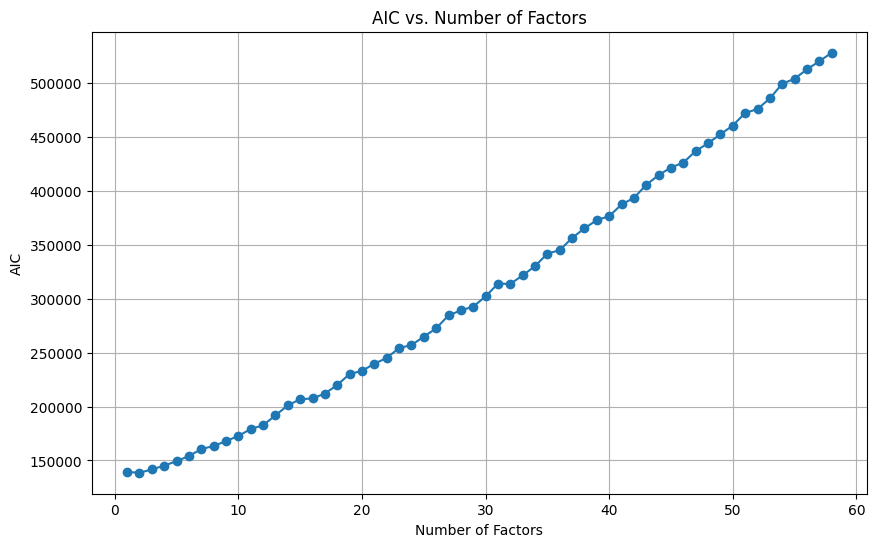

In [36]:
# Create a line plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(fit_df['Number_of_Factors'], fit_df['AIC'], marker='o', linestyle='-')
plt.title('AIC vs. Number of Factors')
plt.xlabel('Number of Factors')
plt.ylabel('AIC')
plt.grid(True)

# Show the plot
plt.show()

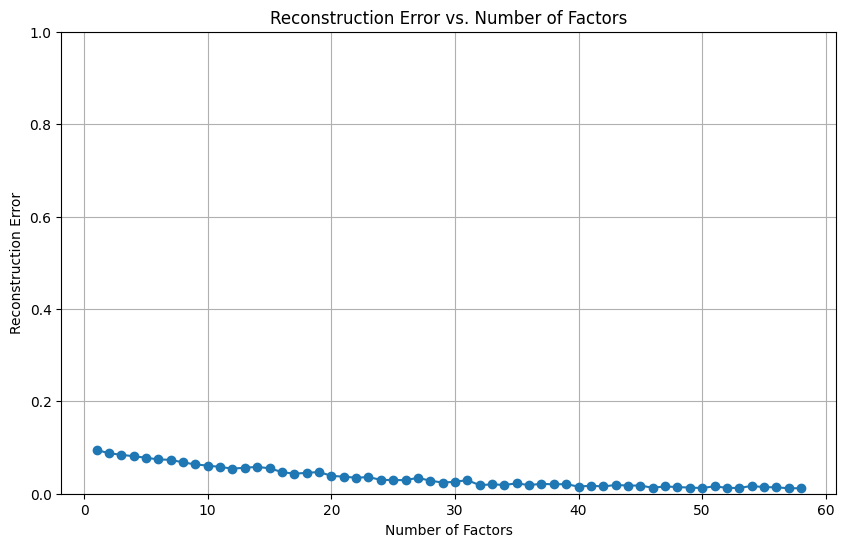

In [37]:
# Create a line plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(fit_df['Number_of_Factors'], fit_df['Reconstruction_Error'], marker='o', linestyle='-')
plt.title('Reconstruction Error vs. Number of Factors')
plt.xlabel('Number of Factors')
plt.ylabel('Reconstruction Error')
plt.grid(True)

# Set x-axis limits from 0 to 1
plt.ylim(0, 1)

# Show the plot
plt.show()

In [40]:
model = BEM(np.int8(X), latent_size=4, alpha=0.95, beta=0.95, mask=np.ones(X.shape, dtype=np.int8), max_iter=200)
model.run()

Factor noise: 0
iteration: 10 --loss: 60161.382688907295
iteration: 20 --loss: 53695.57651692352
iteration: 30 --loss: 50364.049001962965
iteration: 40 --loss: 48795.082212551475
iteration: 50 --loss: 48152.0167725719
iteration: 60 --loss: 47813.67360086592
iteration: 70 --loss: 47574.679104091156
iteration: 80 --loss: 47269.5830623662
iteration: 90 --loss: 46815.212310693
iteration: 100 --loss: 46497.16331035188
iteration: 110 --loss: 46303.14221094116
iteration: 120 --loss: 46182.18731143343
iteration: 130 --loss: 46102.75295759554
iteration: 140 --loss: 46059.654485896324
iteration: 150 --loss: 46043.611226254114
iteration: 160 --loss: 46039.403968982595
iteration: 170 --loss: 46039.268879318595
iteration: 180 --loss: 46040.55472138227
iteration: 190 --loss: 46040.823120750625
iteration: 200 --loss: 46041.250012951896
Factor noise: 0.08223985352456516
iteration: 10 --loss: 56622.27974510558
iteration: 20 --loss: 56525.983415613104
iteration: 30 --loss: 56450.459872942185
iteration: 

In [42]:
U = model.U # Latent groups of patients
Z = model.Z # Latent groups of deficits
X_hat = (model.X_hat > 0.5).astype(int) # Binarise the reconstructed matrix

print("U Shape:", U.shape)
print("Z Shape:", Z.shape)
print("X_hat Shape:", X_hat.shape)

U Shape: (4068, 4)
Z Shape: (4, 58)
X_hat Shape: (4068, 58)


In [43]:
U

array([[0.48676868, 0.99330715, 0.00699532, 0.14979531],
       [0.00836291, 0.99330715, 0.00679924, 0.00669285],
       [0.30546544, 0.99330715, 0.00692026, 0.06781035],
       ...,
       [0.25505819, 0.02929284, 0.0074427 , 0.9353101 ],
       [0.55749019, 0.03184253, 0.00704296, 0.05576617],
       [0.51011149, 0.03173689, 0.00824895, 0.00669285]])

In [50]:
Z[:1]

array([[0.00669285, 0.00669285, 0.14755778, 0.53540297, 0.00669285,
        0.99330715, 0.00669285, 0.00669285, 0.00669285, 0.00669285,
        0.00669285, 0.00669285, 0.00669285, 0.00669285, 0.00669285,
        0.00669285, 0.00669285, 0.00669285, 0.00669285, 0.00669285,
        0.00669285, 0.00669285, 0.00669285, 0.00669285, 0.00669285,
        0.00669285, 0.00669285, 0.00669285, 0.00669285, 0.00669285,
        0.00669285, 0.0233333 , 0.99330715, 0.00669285, 0.0068396 ,
        0.00669285, 0.00669285, 0.00669285, 0.00669285, 0.00669285,
        0.00669285, 0.99330715, 0.00669285, 0.00669285, 0.00669285,
        0.00669285, 0.00669285, 0.00669285, 0.00669285, 0.4867858 ,
        0.71488868, 0.00669285, 0.00669285, 0.00669285, 0.18676086,
        0.00669285, 0.00669285, 0.00669285]])

In [51]:
X_hat

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [52]:
X

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [65]:
factors = pd.DataFrame(Z)
factors.columns = deficits.columns
factors_transposed = factors.transpose()
factors_transposed = factors_transposed.reset_index()
factors_transposed.columns = ["Deficit", "Factor1", "Factor2", "Factor3", "Factor4"]
factors_transposed

,Deficit,Factor1,Factor2,Factor3,Factor4
0,mob-walk100m,0.006693,0.006693,0.006693,0.553451
1,mob-sit2hrs,0.006693,0.006693,0.006693,0.461521
2,mob-stand_from_seated,0.147558,0.006693,0.006693,0.993307
3,mob-stairs_several_flights,0.535403,0.006693,0.006693,0.993307
4,mob-stairs_1flight,0.006693,0.006693,0.006693,0.719517
5,mob-kneeling,0.993307,0.006693,0.006693,0.993307
6,mob-extend_arms,0.006693,0.006693,0.006693,0.361996
7,mob-push_pull,0.006693,0.006693,0.006693,0.939513
8,mob-lift_10lb,0.006693,0.006693,0.006693,0.993307
9,mob-pick_up_coin,0.006693,0.006693,0.006693,0.118174


In [67]:
# Convert the dataframe to a long format
factors_long = pd.melt(factors_transposed, id_vars=["Deficit"], var_name="Factor", value_name="Loading")
factors_long

,Deficit,Factor,Loading
0,mob-walk100m,Factor1,0.006693
1,mob-sit2hrs,Factor1,0.006693
2,mob-stand_from_seated,Factor1,0.147558
3,mob-stairs_several_flights,Factor1,0.535403
4,mob-stairs_1flight,Factor1,0.006693
...,...,...,...
227,gen-pain_walking,Factor4,0.291873
228,mem_day_of_month,Factor4,0.068701
229,mem_month,Factor4,0.006693
230,mem_year,Factor4,0.006693


c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


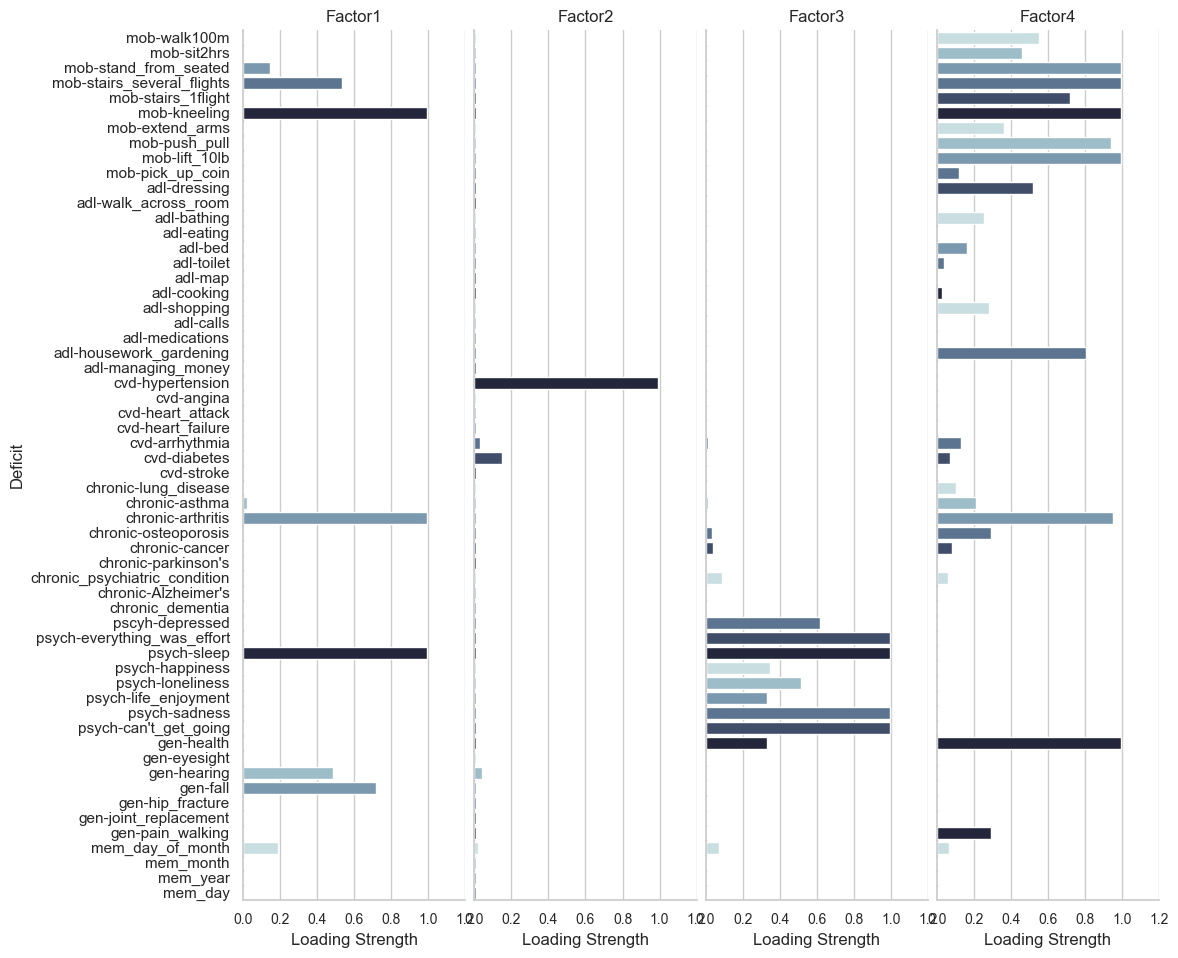

In [113]:
# Define a custom color palette
cmap = sns.cubehelix_palette(start=0, rot=-.2, dark=0.15, light=0.85, reverse=False)

# Create a faceted bar chart
sns.set(style="whitegrid")
g = sns.FacetGrid(factors_long, col="Factor", col_wrap=4, height = 8)
g.map(sns.barplot, "Loading", "Deficit", palette=cmap)

g.set_axis_labels("Loading Strength", "Deficit")
g.set_titles(col_template="{col_name}")

# Increase the font size of x-axis labels
g.set_xticklabels(fontsize=10)

# Set the overall figure size to 1000x1000
g.fig.set_size_inches(10, 10)

plt.show()

In [111]:
cmap = sns.cubehelix_palette(start=0, rot=-.2, dark=0.2, light=0.8, reverse=False)
cmap

[[0.6985682101920605, 0.8389611983244679, 0.8676578634806952],
 [0.557042140675216, 0.7252022143299424, 0.7942811850773824],
 [0.43584815099942426, 0.5967033155587427, 0.7088624867429711],
 [0.3346528940532061, 0.461524410769568, 0.6047309985005622],
 [0.2457040506190906, 0.324844378662893, 0.47525167342197433],
 [0.16241292712216232, 0.19631021410003227, 0.3223012135626958]]

In [118]:
confusion = confusion_matrix(X.flatten(), X_hat.flatten())
confusion

array([[206895,   3045],
       [ 15372,  10632]], dtype=int64)

In [120]:
# Calculate the overall F1 score
f1 = f1_score(X.flatten(), X_hat.flatten())
f1

0.5358735918953655

In [156]:
# Calculate F1 score for each column
f1_scores = [f1_score(X[:, i], X_hat[:, i]) for i in range(X.shape[1])]
f1_scores = pd.DataFrame(data ={"F1_Score": f1_scores})
f1_scores["Deficit"] = deficits.columns

# Calculate prevalence for each column
prevalence = deficits.mean()
prevalence = pd.DataFrame(data = {"Prevalence": prevalence})
prevalence["Deficit"] = deficits.columns

f1_scores= f1_scores.merge(prevalence, on="Deficit", how="inner")
f1_scores.sort_values(by = "F1_Score", ascending = False)



,F1_Score,Deficit,Prevalence
23,1.000000,cvd-hypertension,0.451327
5,0.791550,mob-kneeling,0.405113
32,0.711709,chronic-arthritis,0.475910
7,0.706306,mob-push_pull,0.142085
3,0.699524,mob-stairs_several_flights,0.328663
41,0.682127,psych-sleep,0.411504
8,0.666185,mob-lift_10lb,0.201573
21,0.652482,adl-housework_gardening,0.130531
4,0.631222,mob-stairs_1flight,0.117994
40,0.621940,psych-everything_was_effort,0.160767


In [158]:
# Calculate correlation between F1 Scores and Prevalence
f1_scores['F1_Score'].corr(f1_scores['Prevalence'])

0.8015249723030161

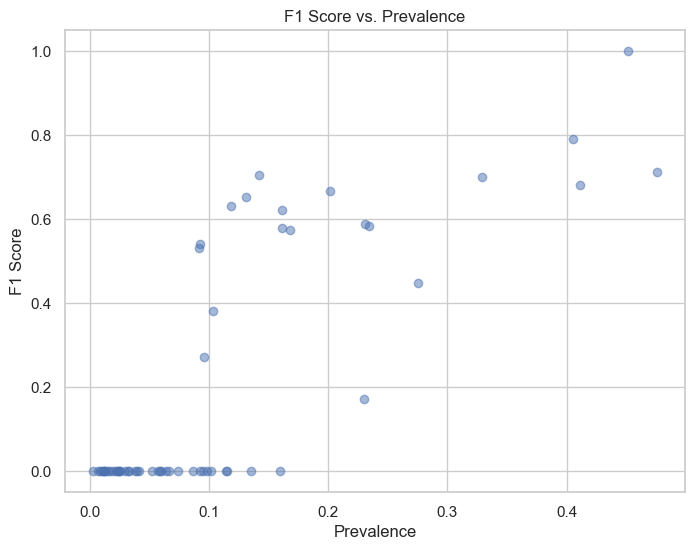

In [157]:
# Create the scatterplot
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.scatter(f1_scores['Prevalence'], f1_scores['F1_Score'], alpha=0.5)
plt.title('F1 Score vs. Prevalence')
plt.xlabel('Prevalence')
plt.ylabel('F1 Score')

# Display the plot
plt.grid(True)
plt.show()

In [170]:
# Extract individual characteristics
characteristics = elsa.dropna().loc[:, 'idauniq': 'frailty']
characteristics


,idauniq,indsex,age,frailty
1,104232,2,66,0.103448
2,105961,1,73,0.017241
3,105988,2,82,0.068966
4,106516,2,81,0.034483
5,106596,2,68,0.000000
...,...,...,...,...
4966,151434,2,65,0.034483
4967,160176,1,70,0.206897
4968,160346,2,65,0.189655
4969,160837,1,71,0.086207


In [175]:
patients = pd.DataFrame(U)
patients.columns = ["Factor1", "Factor2", "Factor3", "Factor4"]
patients["idauniq"] = characteristics["idauniq"].values
patients["indsex"] = characteristics["indsex"].values
patients["age"] = characteristics["age"].values
patients["frailty"] = characteristics["frailty"].values
patients

,Factor1,Factor2,Factor3,Factor4,idauniq,indsex,age,frailty
0,0.486769,0.993307,0.006995,0.149795,104232,2,66,0.103448
1,0.008363,0.993307,0.006799,0.006693,105961,1,73,0.017241
2,0.305465,0.993307,0.006920,0.067810,105988,2,82,0.068966
3,0.050223,0.993307,0.006862,0.011100,106516,2,81,0.034483
4,0.008346,0.026972,0.006789,0.006693,106596,2,68,0.000000
...,...,...,...,...,...,...,...,...
4063,0.185643,0.030426,0.007583,0.006693,151434,2,65,0.034483
4064,0.330593,0.030673,0.011992,0.840559,160176,1,70,0.206897
4065,0.255058,0.029293,0.007443,0.935310,160346,2,65,0.189655
4066,0.557490,0.031843,0.007043,0.055766,160837,1,71,0.086207


In [180]:
patients['Factor4'].corr(patients['age'])

0.18661953031365933

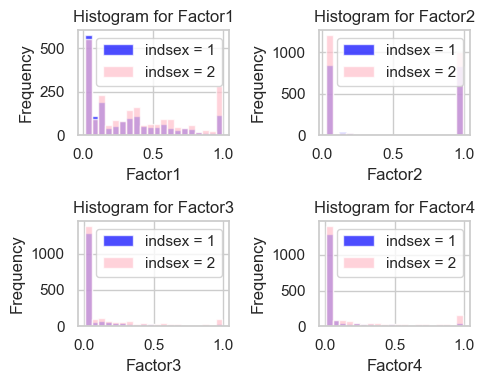

In [185]:
# List of columns you want to create histograms for
columns_to_plot = ['Factor1', 'Factor2', 'Factor3', 'Factor4']

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(5, 4))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Create histograms for each column and plot them, differentiating by 'indsex'
colors = {1: 'blue', 2: 'pink'}

for i, column in enumerate(columns_to_plot):
    for indsex_value, color in colors.items():
        data = patients[patients['indsex'] == indsex_value][column]
        axes[i].hist(data, bins=20, color=color, alpha=0.7, label=f'indsex = {indsex_value}')
    axes[i].set_title(f'Histogram for {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()
    axes[i].grid(True)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# To do for Sohan

In [ ]:
# Option to randomise the initialisation?

In [ ]:
# How is convergence defined in the code?

# For loop running same model multiple times
## Check mean and std to check variance and take the best value

In [194]:
# For loop running same model multiple times
# Check mean and std to check variance and take the best value

best_model = None
best_reconstruction = float('inf')

# Create empty lists to store AIC and reconstruction error values
aic_values_4factor = []
reconstruction_values_4factor = []

# Loop over the iterations
for i in range(1, 5):
    model = BEM(np.int8(X), latent_size=4, alpha=0.95, beta=0.95, mask=np.ones(X.shape, dtype=np.int8), max_iter=200)
    model.run()
    aic_values_4factor.append(model.AIC)
    reconstruction_value = np.abs((model.X_hat > 0.5) - X).mean()
    reconstruction_values_4factor.append(reconstruction_value)

    # Check if this model has the lowest reconstruction value
    if reconstruction_value < best_reconstruction:
        best_reconstruction = reconstruction_value
        best_model = model

# Calculate mean and standard deviation
mean_reconstruction = np.mean(reconstruction_values_4factor)
std_reconstruction = np.std(reconstruction_values_4factor)

# Print the results
print("Mean AIC:", np.mean(aic_values_4factor))
print("Standard Deviation AIC:", np.std(aic_values_4factor))

print("Mean Reconstruction:", mean_reconstruction)
print("Standard Deviation Reconstruction:", std_reconstruction)

# Use the best model for subsequent code
if best_model is not None:
    print("Best Model AIC:", best_model.AIC)

Factor noise: 0
iteration: 10 --loss: 60130.10969134786
iteration: 20 --loss: 53887.519777302834
iteration: 30 --loss: 49338.26054048322
iteration: 40 --loss: 47876.06989732724
iteration: 50 --loss: 47060.849730222166
iteration: 60 --loss: 46713.888434486056
iteration: 70 --loss: 46510.20748641179
iteration: 80 --loss: 46310.32046274183
iteration: 90 --loss: 46148.02542985702
iteration: 100 --loss: 46026.84653034934
iteration: 110 --loss: 45984.423710966184
iteration: 120 --loss: 45964.691242954555
iteration: 130 --loss: 45950.63899096322
iteration: 140 --loss: 45937.5294259577
iteration: 150 --loss: 45934.27922431742
iteration: 160 --loss: 45933.32299092926
iteration: 170 --loss: 45932.669542020034
iteration: 180 --loss: 45930.55426270677
iteration: 190 --loss: 45930.01289147074
iteration: 200 --loss: 45923.802355338536
Factor noise: 0.08260010850032211
iteration: 10 --loss: 56434.66726420609
iteration: 20 --loss: 56394.733609376606
iteration: 30 --loss: 56388.06979089104
iteration: 4

[145262.65404445626, 145224.7834710494, 145192.57133271472, 145131.9638949717]


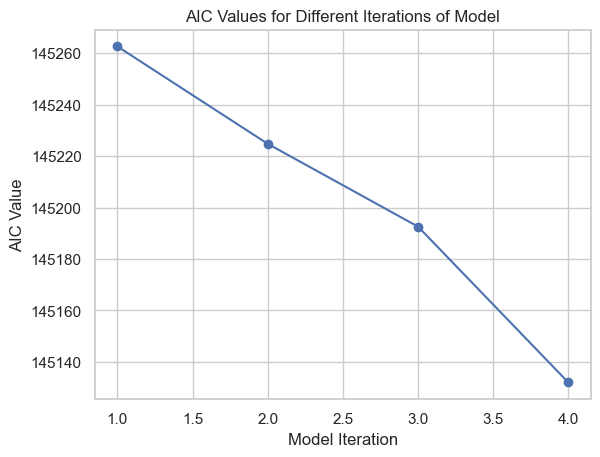

In [197]:
print("AIC Values:", aic_values_4factor)
print("Mean AIC:", np.mean(aic_values_4factor))
print("Standard Deviation AIC:", np.std(aic_values_4factor))

# Plot the AIC values
plt.plot(range(1, 5), aic_values_4factor, marker='o')
plt.title('AIC Values for Different Iterations of Model')
plt.xlabel('Model Iteration')
plt.ylabel('AIC Value')
plt.grid(True)
plt.show()

Reconstruction Error Values: [0.0809175058488455, 0.08090055267351574, 0.08092174414267793, 0.07999779608720714]
Mean Reconstruction: 0.08068439968806158
Standard Deviation Reconstruction: 0.00039649006613015506


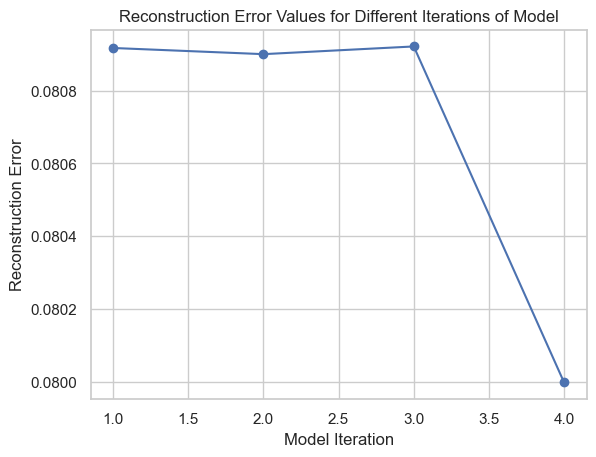

In [200]:
print("Reconstruction Error Values:", reconstruction_values_4factor)
print("Mean Reconstruction:", mean_reconstruction)
print("Standard Deviation Reconstruction:", std_reconstruction)

# Plot the reconstruction error
plt.plot(range(1, 5), reconstruction_values_4factor, marker='o')
plt.title('Reconstruction Error Values for Different Iterations of Model')
plt.xlabel('Model Iteration')
plt.ylabel('Reconstruction Error')
plt.grid(True)
plt.show()

# For loop adjusting alpha and beta parametres

In [216]:
# Create an empty list to store AUC values
auc_values = []

# Define a range of alpha and beta values to explore
alpha_values = [0.85]
beta_values = [0.85]

# Assuming you have true_labels and predicted_labels for ROC calculation
true_labels = X

# Loop over alpha values
for alpha in alpha_values:
    for beta in beta_values:
        model = BEM(np.int8(X), latent_size=4, alpha=alpha, beta=beta, mask=np.ones(X.shape, dtype=np.int8), max_iter=200)
        model.run()
        
        # Calculate ROC AUC and store it in the list
        predicted_labels = (model.X_hat > 0.5).astype(int)
        auc = roc_auc_score(true_labels, predicted_labels)
        auc_values.append((alpha, beta, auc))

Factor noise: 0
iteration: 10 --loss: 60163.996018777994
iteration: 20 --loss: 54918.786501309216
iteration: 30 --loss: 50005.37531997995
iteration: 40 --loss: 48560.38788794636
iteration: 50 --loss: 47833.2371220215
iteration: 60 --loss: 47562.417604532784
iteration: 70 --loss: 47482.744847917675
iteration: 80 --loss: 47429.01668533758
iteration: 90 --loss: 47396.82109687326
iteration: 100 --loss: 47378.507281321545
iteration: 110 --loss: 47351.76342098556
iteration: 120 --loss: 47315.344990963116
iteration: 130 --loss: 47296.093518769754
iteration: 140 --loss: 47265.016785004445
iteration: 150 --loss: 47212.35380019467
iteration: 160 --loss: 47167.77153834603
iteration: 170 --loss: 47147.57467662603
iteration: 180 --loss: 47133.79049361411
iteration: 190 --loss: 47117.595885710805
iteration: 200 --loss: 47090.68004410444
Factor noise: 0.08183297731665141
iteration: 10 --loss: 57271.434161516925
iteration: 20 --loss: 57102.70722117279
iteration: 30 --loss: 57014.7241017138
iteration: 

In [227]:
# Plot AUC ROC
model = BEM(np.int8(X), latent_size=4, alpha=0.95, beta=0.95, mask=np.ones(X.shape, dtype=np.int8), max_iter=200)
model.run()
model.X_hat


Factor noise: 0
iteration: 10 --loss: 60122.681960324335
iteration: 20 --loss: 52532.61487480124
iteration: 30 --loss: 49096.5987983826
iteration: 40 --loss: 48466.003113983126
iteration: 50 --loss: 48137.39012205327
iteration: 60 --loss: 47806.903480480534
iteration: 70 --loss: 47491.98331819021
iteration: 80 --loss: 47242.248455870635
iteration: 90 --loss: 46906.52836525806
iteration: 100 --loss: 46640.80431114772
iteration: 110 --loss: 46440.59767349722
iteration: 120 --loss: 46292.37893688386
iteration: 130 --loss: 46222.679998581465
iteration: 140 --loss: 46176.86235189357
iteration: 150 --loss: 46094.08725426958
iteration: 160 --loss: 46035.92388362796
iteration: 170 --loss: 46024.39494301768
iteration: 180 --loss: 46017.79173105588
iteration: 190 --loss: 46012.87623961545
iteration: 200 --loss: 46003.869167330704
Factor noise: 0.08135828840741871
iteration: 10 --loss: 56285.42819196247
iteration: 20 --loss: 56238.511019070465
iteration: 30 --loss: 56226.04411842437
iteration: 40

array([[0.08559524, 0.07431712, 0.16158433, ..., 0.00787329, 0.00787329,
        0.00787329],
       [0.00504556, 0.00456188, 0.00830453, ..., 0.00171228, 0.00171228,
        0.00171228],
       [0.03457302, 0.03048885, 0.06209114, ..., 0.00642738, 0.00642738,
        0.00642738],
       ...,
       [0.48044846, 0.41195119, 0.9419657 , ..., 0.00840672, 0.00840672,
        0.00840672],
       [0.05434554, 0.04722308, 0.10233487, ..., 0.00526186, 0.00526186,
        0.00526186],
       [0.0090592 , 0.00857746, 0.01230502, ..., 0.00573936, 0.00573936,
        0.00573936]])

In [231]:
print(model.X_hat.shape)
print(X.shape)

(4068, 58)
(4068, 58)


In [241]:
fpr, tpr, thresholds = roc_curve(X[:, 1], model.X_hat[:, 1])

# Calculate ROC AUC score
roc_auc = roc_auc_score(X[:, 10], model.X_hat[:, 10])


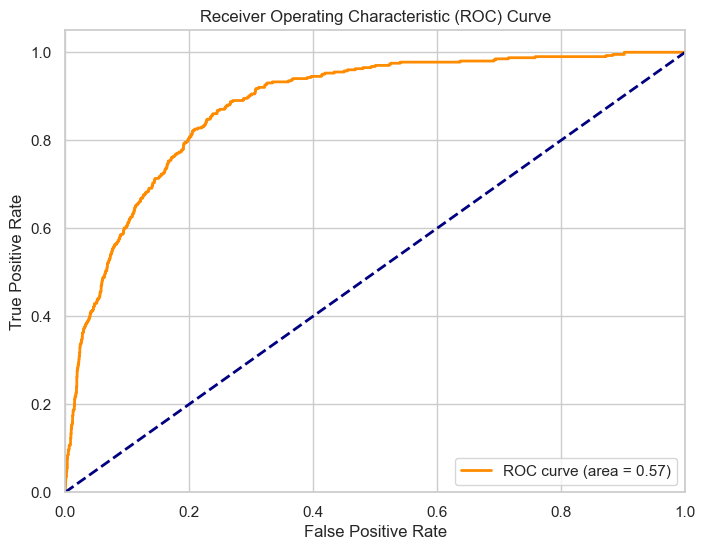

In [242]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [201]:
# For loop adjusting alpha and beta parametres

# Create an empty list to store reconstruction values
aic_values_parameter_tuning = []
reconstruction_values_parameter_tuning = []

# Define a range of alpha and beta values to explore
alpha_values = [0.85, 0.9, 0.95]
beta_values = [0.85, 0.9, 0.95]

# Loop over alpha values
for alpha in alpha_values:
    for beta in beta_values:
        model = BEM(np.int8(X), latent_size=4, alpha=alpha, beta=beta, mask=np.ones(X.shape, dtype=np.int8), max_iter=200)
        model.run()
        aic_values_parameter_tuning.append(model.AIC)
        reconstruction_values_parameter_tuning.append(np.abs((model.X_hat > 0.5) - X).mean())

# Print the results
print("AIC:", aic_values_parameter_tuning)
print("Reconstruction:", reconstruction_values_parameter_tuning)

Factor noise: 0
iteration: 10 --loss: 60120.946685418494
iteration: 20 --loss: 54463.54220846246
iteration: 30 --loss: 50210.9261564366
iteration: 40 --loss: 48756.55756795595
iteration: 50 --loss: 47820.623658376426
iteration: 60 --loss: 47473.78510028983
iteration: 70 --loss: 47248.46991289849
iteration: 80 --loss: 47108.49660983534
iteration: 90 --loss: 46996.11677717584
iteration: 100 --loss: 46875.886609955036
iteration: 110 --loss: 46799.19974974732
iteration: 120 --loss: 46741.65456332788
iteration: 130 --loss: 46678.240691266314
iteration: 140 --loss: 46663.74981788873
iteration: 150 --loss: 46663.672435268796
iteration: 160 --loss: 46661.70565231885
iteration: 170 --loss: 46659.79985183393
iteration: 180 --loss: 46658.60735371622
iteration: 190 --loss: 46657.91837920326
iteration: 200 --loss: 46657.25191374463
Factor noise: 0.07853134642118469
iteration: 10 --loss: 56480.85413808582
iteration: 20 --loss: 56398.57909739507
iteration: 30 --loss: 56347.791938256116
iteration: 40 

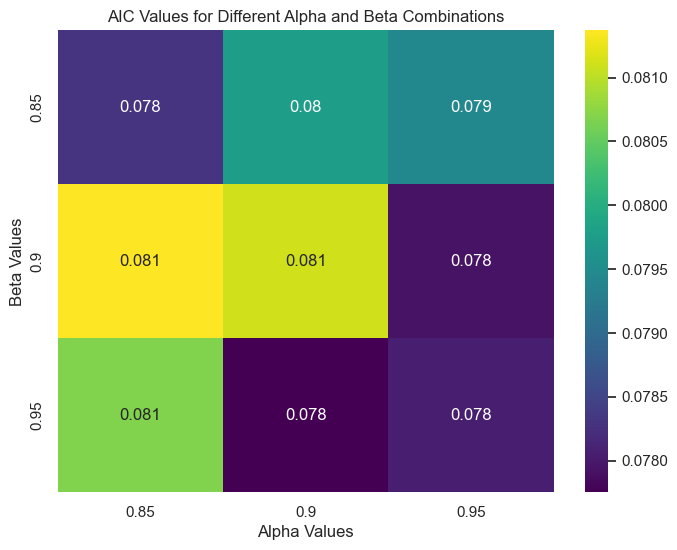

In [206]:
reconstruction_matrix = np.array(reconstruction_values_parameter_tuning).reshape(len(alpha_values), len(beta_values))
reconstruction_matrix

# Create a heatmap of AIC values
plt.figure(figsize=(8, 6))
sns.heatmap(reconstruction_matrix, annot=True, xticklabels=alpha_values, yticklabels=beta_values, cmap="viridis")
plt.xlabel('Alpha Values')
plt.ylabel('Beta Values')
plt.title('AIC Values for Different Alpha and Beta Combinations')
plt.show()

In [ ]:
# Distance measure for comparing original vs reconstructed matrices?

In [293]:
# Plot solutions for several numbers of factors
# Create an empty list to store accuracy values
aic_values = []
reconstruction_values = []

# Initialize dictionaries to store dataframes
U_dict = {}
Z_dict = {}
X_hat_dict = {}

# Loop over the number of factors
for i in range(2,9):
    model = BEM(np.int8(X), latent_size=i, alpha=0.95, beta=0.95, mask=np.ones(X.shape, dtype=np.int8), max_iter=200)
    model.run()

    # Save U, Z, and X_hat dataframes to dictionaries
    U_dict[f'U_model_{i}'] = pd.DataFrame(model.U.T) # Latent groups of patients
    Z_dict[f'Z_model_{i}'] = pd.DataFrame(model.Z.T) # Latent groups of deficits
    X_hat_dict[f'X_hat_model_{i}'] = (model.X_hat > 0.5).astype(int) # Binarise the reconstructed matrix

    # Transform Z dataframe
    Z_dict[f'Z_model_{i}']['Deficit'] = deficits.columns
    Z_dict[f'Z_model_{i}'] = pd.melt(Z_dict[f'Z_model_{i}'], id_vars=["Deficit"], var_name="Factor", value_name="Loading")

    aic_values.append(model.AIC)
    reconstruction_values.append(np.abs((model.X_hat>0.5)-X).mean())

Factor noise: 0
iteration: 10 --loss: 58515.04128289827
iteration: 20 --loss: 54203.85169514857
iteration: 30 --loss: 52286.64857683261
iteration: 40 --loss: 52074.62490431189
iteration: 50 --loss: 52010.61589553769
iteration: 60 --loss: 51989.755676868604
iteration: 70 --loss: 51977.64655177098
iteration: 80 --loss: 51970.47366711415
iteration: 90 --loss: 51967.237051221084
iteration: 100 --loss: 51963.97493335578
iteration: 110 --loss: 51960.583537113125
iteration: 120 --loss: 51956.65911763404
iteration: 130 --loss: 51952.98100327648
iteration: 140 --loss: 51950.970838526504
iteration: 150 --loss: 51949.825242745246
iteration: 160 --loss: 51949.29844590798
iteration: 170 --loss: 51949.14798850517
iteration: 180 --loss: 51949.15673375757
Factor noise: 0.08916946394059608
iteration: 10 --loss: 61461.0086285542
iteration: 20 --loss: 61367.98539733411
iteration: 30 --loss: 61313.87726965357
iteration: 40 --loss: 61278.90297625255
iteration: 50 --loss: 61272.24500561925
iteration: 60 --l

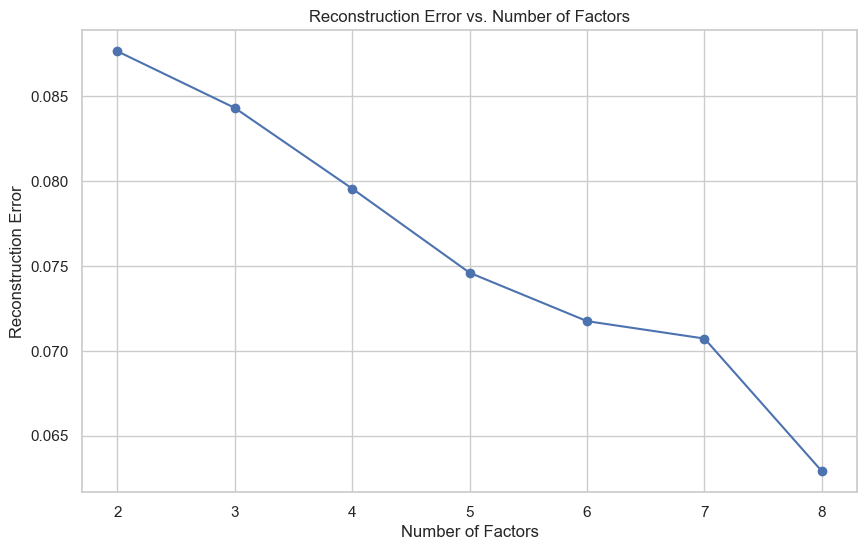

In [300]:
fit_df = pd.DataFrame({'Number_of_Factors': range(2, 9), 'AIC': aic_values, 'Reconstruction_Error': reconstruction_values})

# Plot reconstruction error
# Create a line plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(fit_df['Number_of_Factors'], fit_df['Reconstruction_Error'], marker='o', linestyle='-')
plt.title('Reconstruction Error vs. Number of Factors')
plt.xlabel('Number of Factors')
plt.ylabel('Reconstruction Error')
plt.grid(True)

# Set x-axis limits from 0 to 1
#plt.ylim(0, 1)

# Show the plot
plt.show()

c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


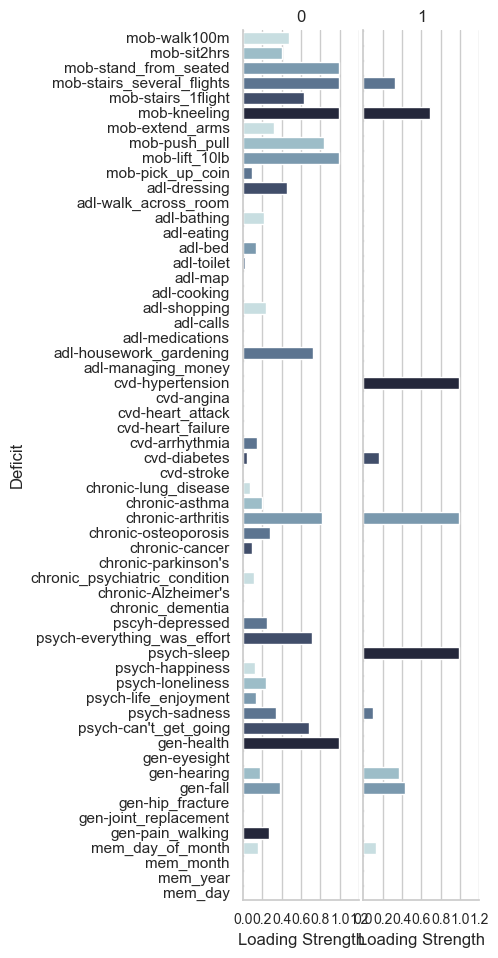

c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


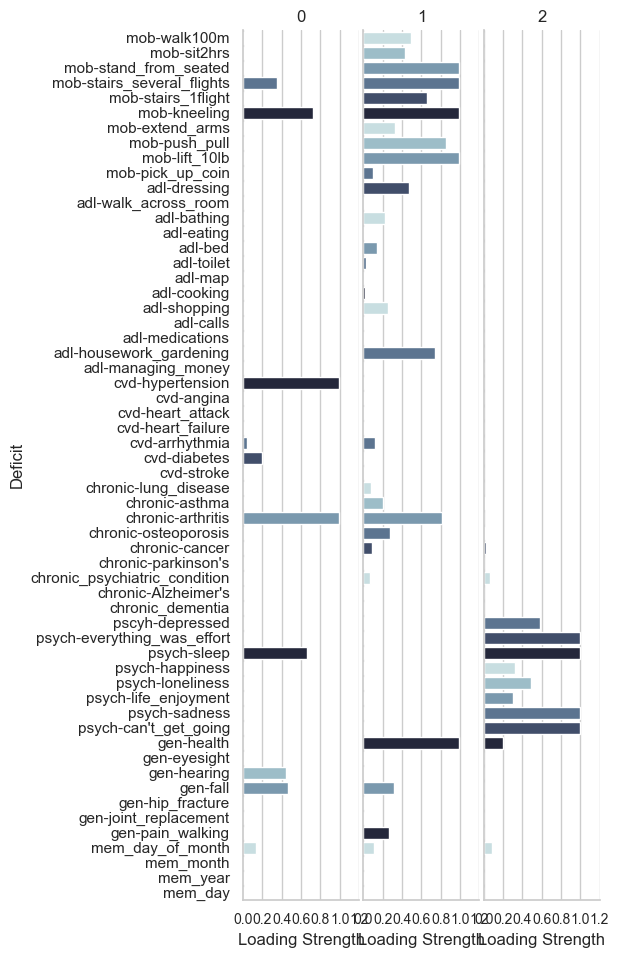

c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


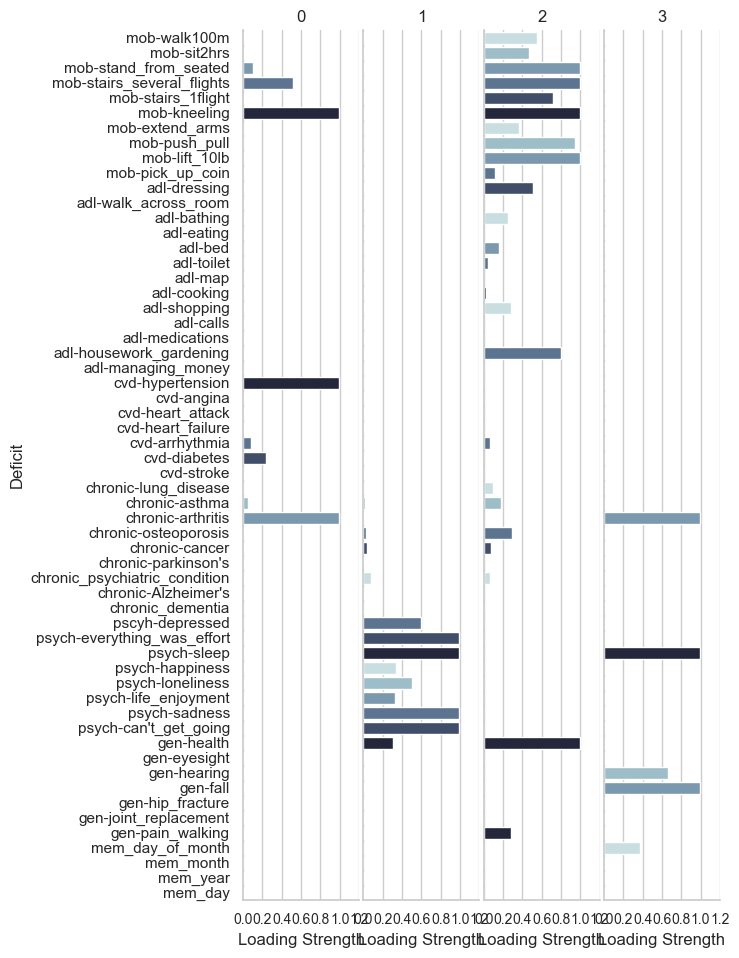

c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


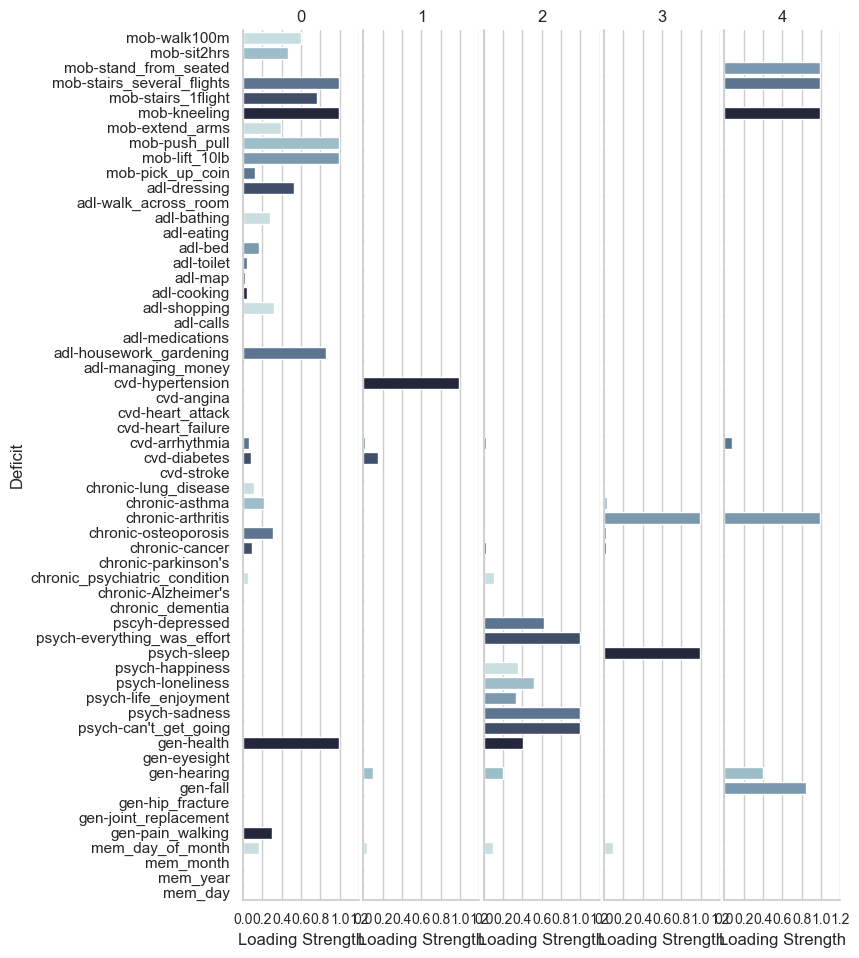

c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


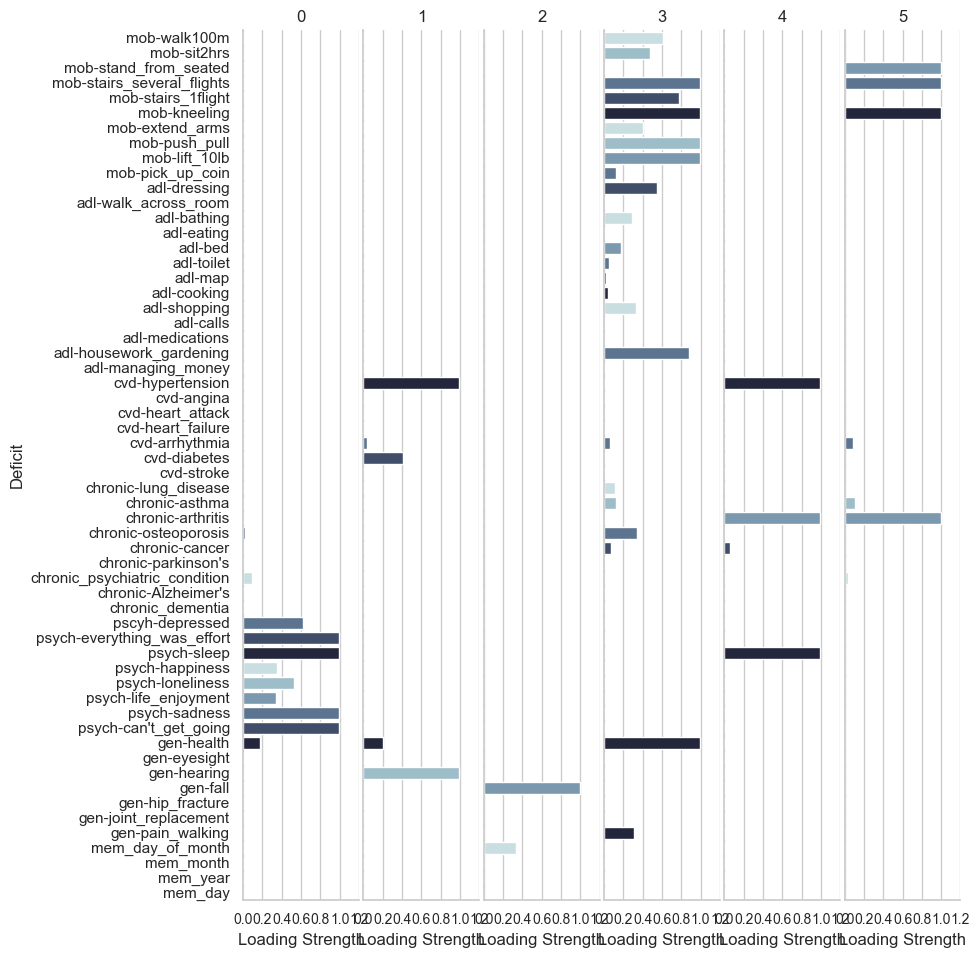

c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


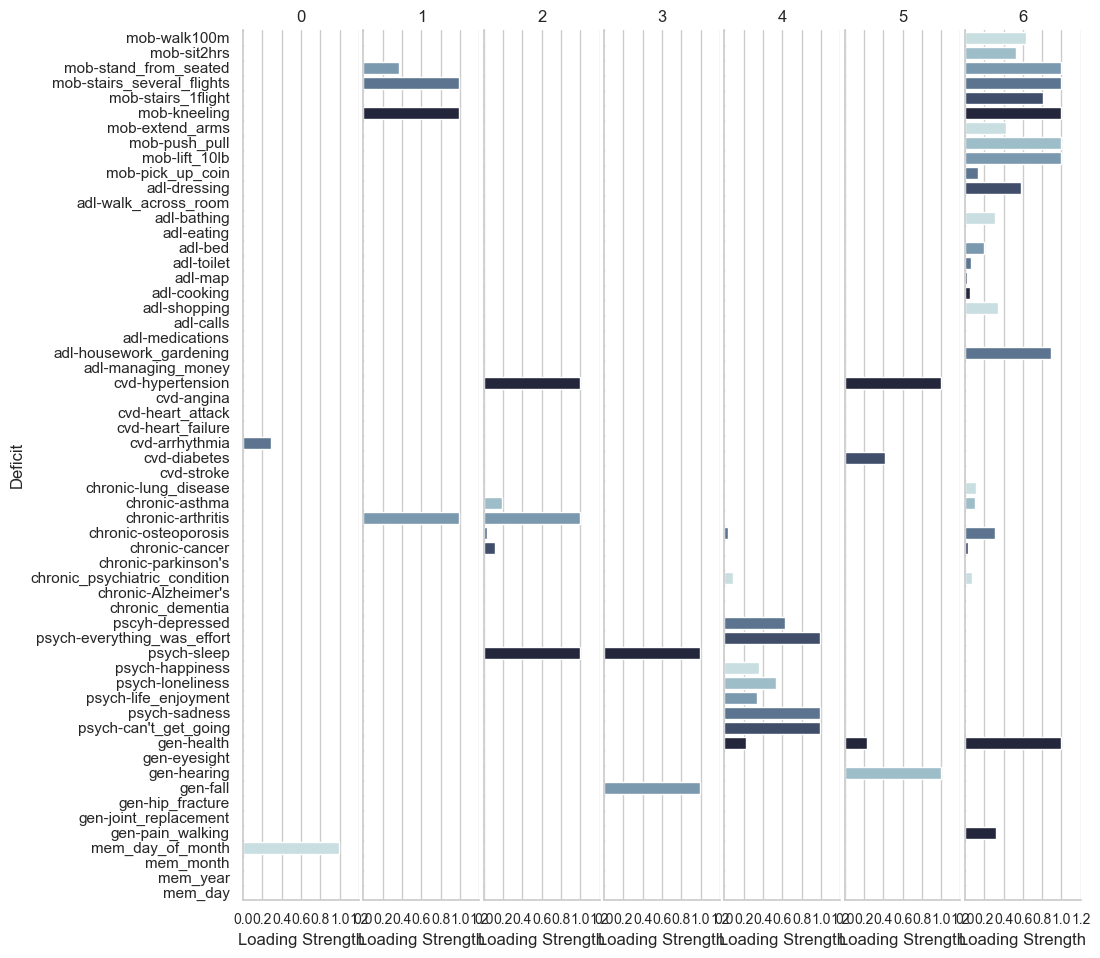

c:\Users\s1989190\AppData\Local\anaconda3\envs\lara\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


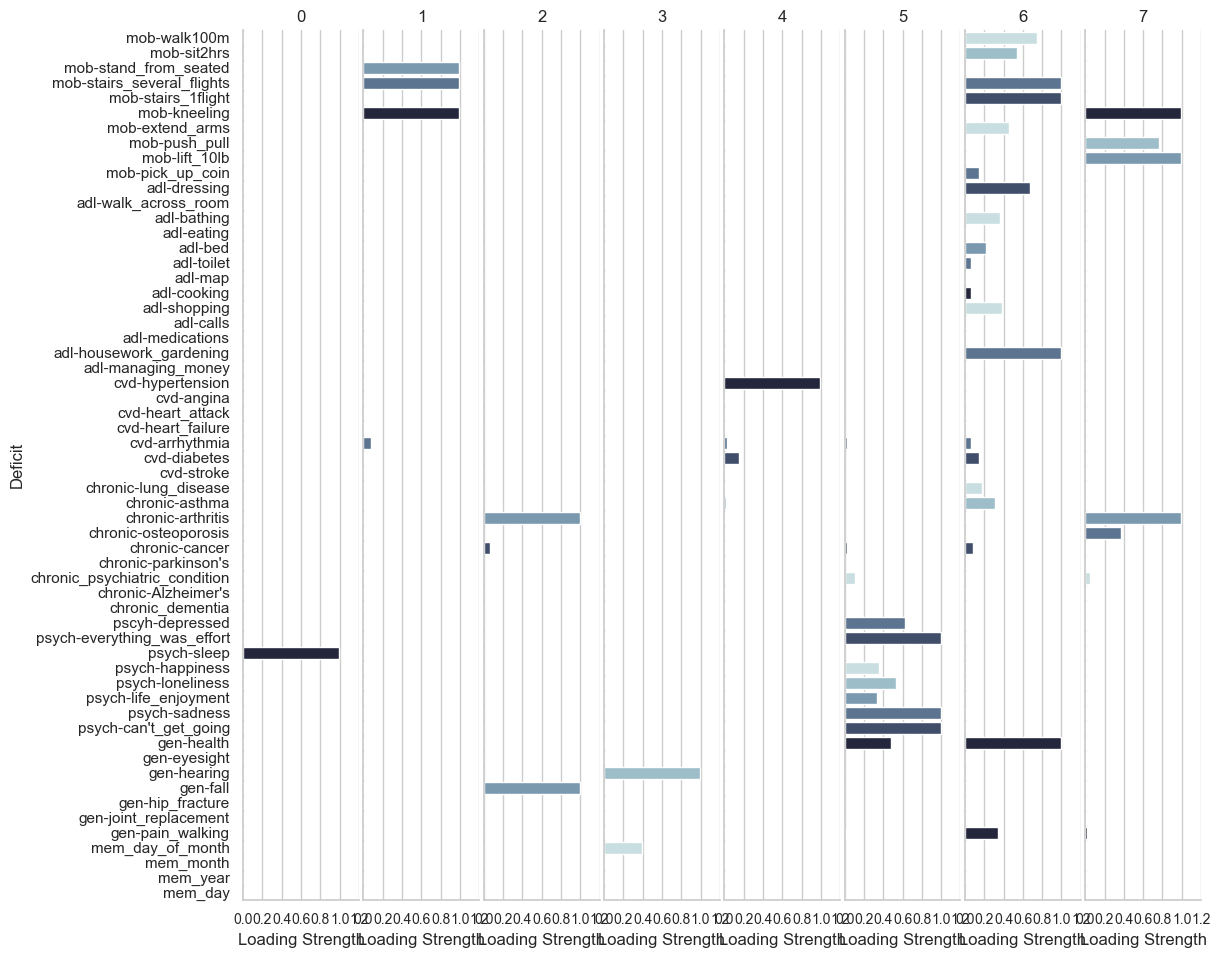

In [296]:
# Plot factor loadings for different numbers of factors
# Define a custom color palette
cmap = sns.cubehelix_palette(start=0, rot=-.2, dark=0.15, light=0.85, reverse=False)

for i in range(2,9):
    #print(Z_dict[f'Z_model_{i}'])
    sns.set(style="whitegrid")
    g = sns.FacetGrid(Z_dict[f'Z_model_{i}'], col="Factor", col_wrap=8, height=8)
    g.map(sns.barplot, "Loading", "Deficit", palette=cmap)

    g.set_axis_labels("Loading Strength", "Deficit")
    g.set_titles(col_template="{col_name}")

    # Increase the font size of x-axis labels
    g.set_xticklabels(fontsize=10)

    # Set the overall figure size to 1000x1000
    g.fig.set_size_inches(10, 10)

    plt.show()


In [312]:
U_dict['U_model_4'].T


#pd.melt(U_dict['U_model_4'], id_vars=["Patient"], var_name="Factor", value_name="Loading")
#U_dict['U_model_4']

,0,1,2,3
0,0.736113,0.007099,0.156610,0.212744
1,0.201678,0.006967,0.006693,0.010354
2,0.776510,0.007020,0.022137,0.010975
3,0.409532,0.006983,0.006693,0.010470
4,0.010402,0.006938,0.006693,0.010245


In [ ]:
# Compute area under the curve / ROC

In [ ]:
# How to link U to patient characteristics?